In [1]:
import numpy as np
import cv2
import os
import pywt

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import joblib
import json 

In [2]:
face_cascade=cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

In [3]:
img_dirs = []
for entry in os.scandir("./dataset/cropped/"):
    if entry.is_dir():
        img_dirs.append(entry.path)
img_dirs

['./dataset/cropped/huzaifa',
 './dataset/cropped/kawish',
 './dataset/cropped/ubaid',
 './dataset/cropped/unknown']

In [4]:
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'huzaifa': ['./dataset/cropped/huzaifa\\huzaifa1.png',
  './dataset/cropped/huzaifa\\huzaifa10.png',
  './dataset/cropped/huzaifa\\huzaifa11.png',
  './dataset/cropped/huzaifa\\huzaifa12.png',
  './dataset/cropped/huzaifa\\huzaifa13.png',
  './dataset/cropped/huzaifa\\huzaifa14.png',
  './dataset/cropped/huzaifa\\huzaifa15.png',
  './dataset/cropped/huzaifa\\huzaifa16.png',
  './dataset/cropped/huzaifa\\huzaifa17.png',
  './dataset/cropped/huzaifa\\huzaifa18.png',
  './dataset/cropped/huzaifa\\huzaifa19.png',
  './dataset/cropped/huzaifa\\huzaifa2.png',
  './dataset/cropped/huzaifa\\huzaifa20.png',
  './dataset/cropped/huzaifa\\huzaifa21.png',
  './dataset/cropped/huzaifa\\huzaifa22.png',
  './dataset/cropped/huzaifa\\huzaifa23.png',
  './dataset/cropped/huzaifa\\huzaifa24.png',
  './dataset/cropped/huzaifa\\huzaifa25.png',
  './dataset/cropped/huzaifa\\huzaifa26.png',
  './dataset/cropped/huzaifa\\huzaifa27.png',
  './dataset/cropped/huzaifa\\huzaifa28.png',
  './dataset/cropped/huza

In [5]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'huzaifa': 0, 'kawish': 1, 'ubaid': 2, 'unknown': 3}

In [6]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [7]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [8]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(187, 4096)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [17]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.850000,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.685714,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.828571,{'logisticregression__C': 1}


In [18]:
best_estimators['svm'].score(X_test,y_test)

0.8936170212765957

In [19]:
best_estimators['random_forest'].score(X_test,y_test)

0.7659574468085106

In [20]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8936170212765957

In [35]:
best_clf = best_estimators['logistic_regression']

In [36]:
joblib.dump(best_clf, 'pehchan2.pkl')

['pehchan2.pkl']

In [23]:
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[12,  1,  1,  0],
       [ 0,  8,  1,  0],
       [ 0,  0,  7,  1],
       [ 0,  1,  0, 15]], dtype=int64)

Text(69.0, 0.5, 'Truth')

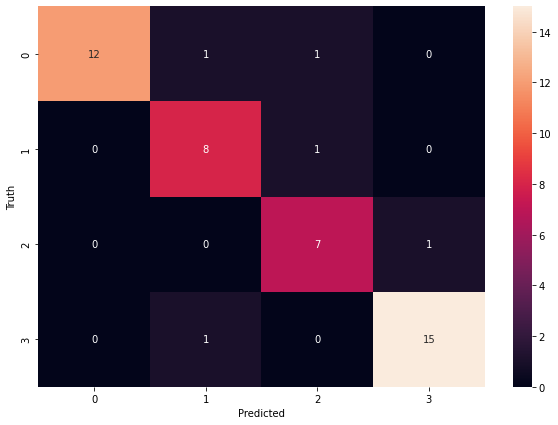

In [38]:
import seaborn as sn
from matplotlib import pyplot as plt
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')